In [1]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import seaborn as sns
import dateparser

In [2]:
def collect_urls(query: str, max_results: int=100):
    q = f"{query} site:tengrinews.kz"
    results = list(search(q, num_results=max_results))
    urls = [u for u in results if "tengrinews.kz" in u]
    return urls[:max_results]

urls = collect_urls("Фонд Булата Утемуратова", max_results=100)
len(urls)

100

In [3]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                     "AppleWebKit/537.36 (KHTML, like Gecko) "
                     "Chrome/114.0.0.0 Safari/537.36")

from selenium.webdriver.chrome.service import Service

service = Service(ChromeDriverManager().install())
driver  = webdriver.Chrome(service=service, options=options)

In [4]:
import time
from bs4 import BeautifulSoup

def parse_article_selenium(url: str):
    driver.get(url)
    time.sleep(2) 

    soup = BeautifulSoup(driver.page_source, "html.parser")

    h1 = soup.select_one("h1.article__title") or soup.select_one("h1.head-single") or soup.select_one("title")
    title = h1.get_text(strip=True) if h1 else None
    date_el = soup.select_one("ol.breadCrumb-ls.date-time li:last-child span")
    date = date_el.get_text(strip=True) if date_el else None

    views_el = soup.select_one(".content_main_meta_stat_view .tn-text-preloader-dark[data-views]")
    views = views_el.get_text(strip=True) if views_el else None

    return {"url": url, "title": title, "date": date, "views": views}

In [5]:
urls = collect_urls("Фонд Булата Утемуратова", max_results=100)
data = [parse_article_selenium(u) for u in urls]
df = pd.DataFrame(data)
df.head(5)

,url,title,date,views
0,https://tengrinews.kz/kazakhstan_news/novyiy-a...,"Новый аэропорт, школы, помощь пострадавшим от ...","10 декабря 2024, 13:02",2324
1,https://tengrinews.kz/kazakhstan_news/fond-bul...,Фонд Булата Утемуратова выделил 680 миллионов ...,"01 апреля 2024, 13:53",9658
2,https://tengrinews.kz/kazakhstan_news/fond-bul...,Фонд Булата Утемуратова начал оформление жилья...,"06 мая 2024, 09:46",9034
3,https://tengrinews.kz/kazakhstan_news/kosshyi-...,В Косшы открылся первый в Казахстане комьюнити...,"20 марта 2025, 12:03",26566
4,https://tengrinews.kz/kazakhstan_news/fond-bul...,Фонд Булата Утемуратова получил премию Америка...,"03 июня 2024, 14:35",4548


In [6]:
df.to_csv("tengrinews_articles.csv", index=False)
print("Saved to tengrinews_articles.csv")

Saved to tengrinews_articles.csv


In [7]:
import dateparser
import pandas as pd

def parse_ru_date(x):
    if isinstance(x, str):
        return dateparser.parse(x, languages=['ru'])
    return pd.NaT

df['date'] = df['date'].apply(parse_ru_date)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['views'] = pd.to_numeric(df['views'], errors='coerce').fillna(0).astype(int)

df.dtypes

/var/folders/3m/ygq196c16zs4wgq2yzkj4m200000gn/T/ipykernel_9681/88715954.py:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  return dateparser.parse(x, languages=['ru'])


url              object
title            object
date     datetime64[ns]
views             int64
dtype: object

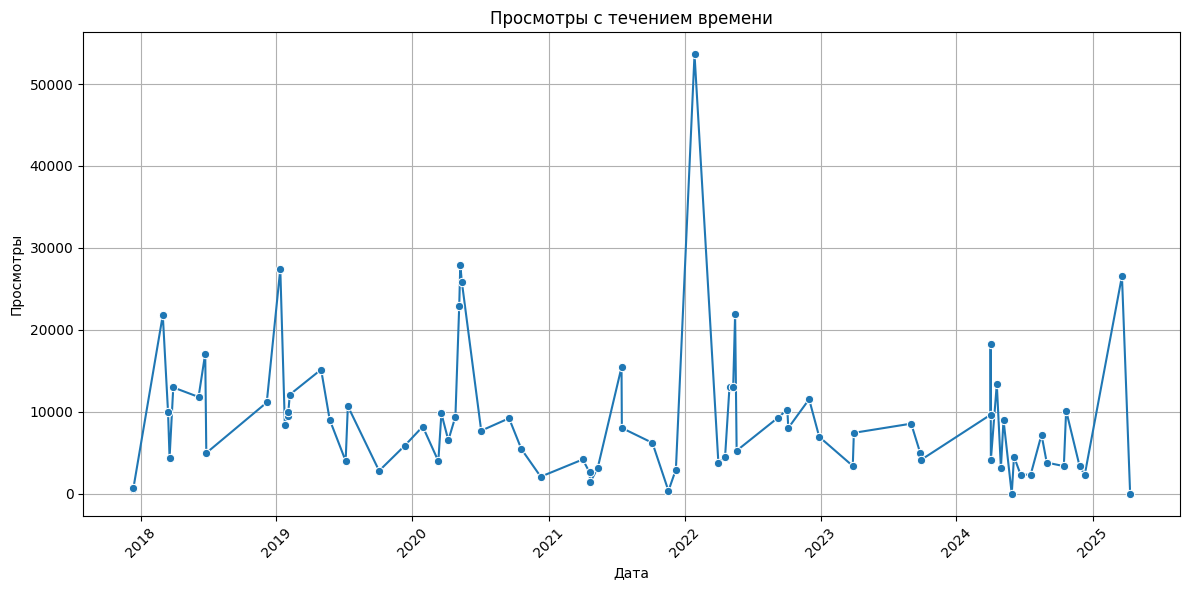

In [8]:
df_sorted = df.sort_values("date")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x="date", y="views", marker="o")
plt.grid(True)
plt.title("Просмотры с течением времени")
plt.xlabel("Дата")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

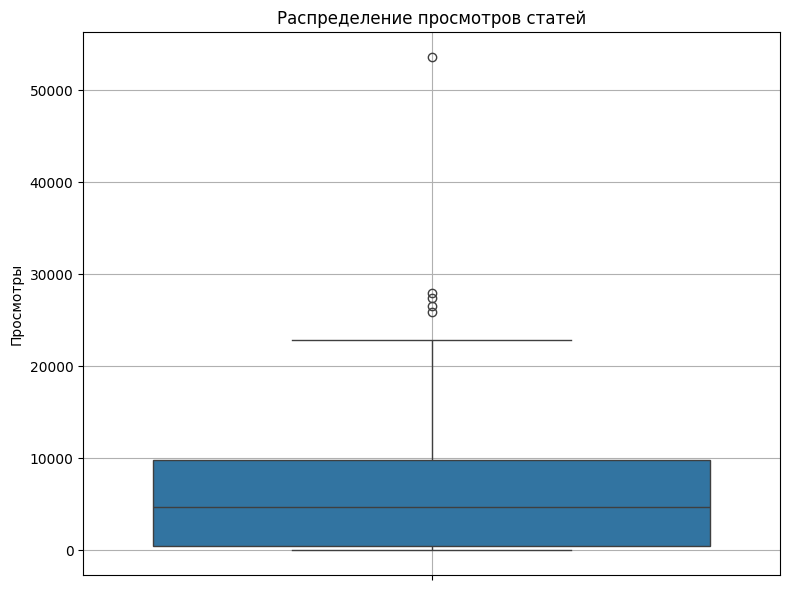

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['views'])
plt.title("Распределение просмотров статей")
plt.ylabel("Просмотры")
plt.tight_layout()
plt.grid(True)
plt.show()

In [10]:
pd.set_option('display.max_colwidth', None)
Q1    = df['views'].quantile(0.25)
Q3    = df['views'].quantile(0.75)
IQR   = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['views'] < lower) | (df['views'] > upper)]
print(f"Number of outliers:{len(outliers)}")
outliers[['title','views']]

Number of outliers:5


,title,views
3,В Косшы открылся первый в Казахстане комьюнити-центр международного уровня,26566
47,"Булат Утемуратов перечислил 10 миллиардов тенге в фонд ""Қазақстан халқына""",53622
69,Булат Утемуратов выделил 6 миллионов долларов на дома пострадавшим от наводнения,27967
70,"""15 миллионов долларов"". В фонде Утемуратова рассказали о перестройке Ботанического сада",27441
99,Утемуратов показал Токаеву результаты реконструкции Ботанического сада Алматы,25886


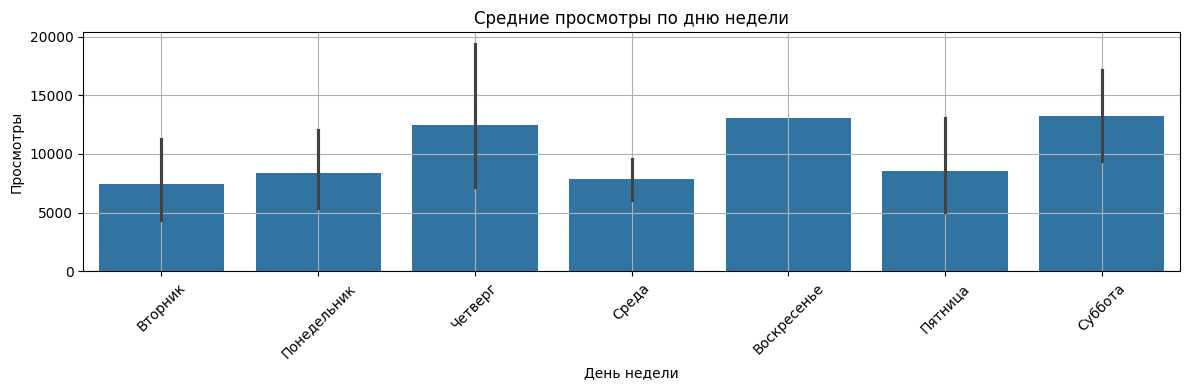

In [14]:
df['dow'] = df['date'].dt.day_name(locale='ru_RU')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=df,
    x='dow',
    y='views',
    estimator='mean', 
)
plt.title("Средние просмотры по дню недели")
plt.xlabel("День недели")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()